In [1]:
import os

os.chdir('/content/template')

# Dataset.py

# dataset.py

In [2]:
import os
import numpy as np
import random
import torch
import tarfile
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

class MNIST(Dataset):
    def __init__(self, data_dir):
        super(MNIST, self).__init__()
        self.fileNames = []                         # Image file Names List
        self.targets = []                           # Image Label List
        self.data_dir = data_dir                    # Root dir

        # all values should be in a range of [0,1]
        # Substract mean of 0.1307, and divide by std 0.3081
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

        for filename in os.listdir(self.data_dir):
            if 'png' in filename:
                self.fileNames.append(os.path.join(self.data_dir, filename))
                label = int(filename.split("_")[1].split(".")[0])
                self.targets.append(label)

    def __len__(self):
        return len(self.fileNames)

    def __getitem__(self, idx):
        img = Image.open(self.fileNames[idx]).convert('L')
        img = self.transform(img)
        label = self.targets[idx]

        return img, label

MNIST Train Dataset Description
Sample Dataset Len: 60000
Sample image shape: torch.Size([1, 28, 28]), Sample label: 6
Sample image mean value: -0.016925698146224022, Sample image std value0.9621476531028748
Sample train image example


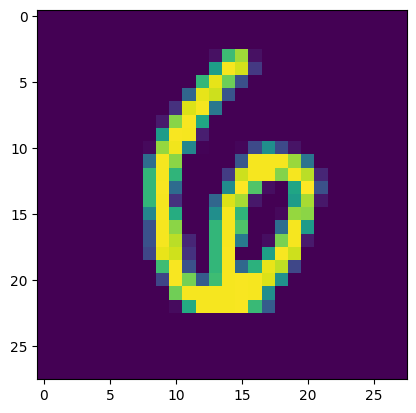


MNIST Test Dataset Description
Sample Test Dataset Len: 10000
Sample image shape: torch.Size([1, 28, 28]), Sample label: 0
Sample image mean value: 0.15902915596961975, Sample image std value1.164345622062683
Sample test image example


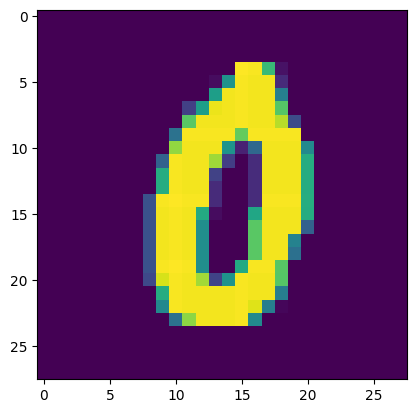

In [3]:
data_dir = '../data/test.tar'
root, _ = os.path.splitext(data_dir)
tar = tarfile.open(data_dir, 'r')
data_dir = os.path.dirname(data_dir)
tar.extractall(data_dir)

data_dir = '../data/train.tar'
root, _ = os.path.splitext(data_dir)
tar = tarfile.open(data_dir, 'r')
data_dir = os.path.dirname(data_dir)
tar.extractall(data_dir)

trainset = MNIST('../data/train')
testset = MNIST('../data/test')

print('MNIST Train Dataset Description')
print(f'Sample Dataset Len: {len(trainset)}')
print(f'Sample image shape: {trainset[0][0].shape}, Sample label: {trainset[0][1]}')
print(f'Sample image mean value: {torch.mean(trainset[0][0].reshape(-1))}, Sample image std value{torch.std(trainset[0][0].reshape(-1))}')

print('Sample train image example')
plt.imshow(trainset[0][0].reshape(28, 28))
plt.show()

print()

print('MNIST Test Dataset Description')
print(f'Sample Test Dataset Len: {len(testset)}')
print(f'Sample image shape: {testset[0][0].shape}, Sample label: {testset[0][1]}')
print(f'Sample image mean value: {torch.mean(testset[0][0].reshape(-1))}, Sample image std value{torch.std(testset[0][0].reshape(-1))}')

print('Sample test image example')
plt.imshow(testset[0][0].reshape(28, 28))
plt.show()

# model.py

## Number of Model Parameter
### LeNet5
- ConvEncoder
 - nn.Conv2d(1, 6, kernel_size=5): input_channel(1) * output_channel(6) * kernel_size(5*5) + biases(6) = 156
 - nn.Conv2d(6, 16, kernel_size=5) = input_channel(6) * output_channel(16) * kernel_size(5*5) + biases(16) = 2416
- Fc
 - nn.Linear(16 * 4 * 4, 120): input_size(16*4*4) * output_size(120) + biases(120) = 30840
 - nn.Linear(120, 84): input_size(120) * output_size(84) + biases(84) = 10164
 - nn.Linear(84, 10): input_size(84) * output_size(10) + biases(10) = 850
- Number of LeNet5 Parameter: 156 + 2416 + 30840 + 10164 + 850 = 44426

### CustomMLP
- MLP
 - nn.Linear(28*28, 64): input_size(28*28) * output_size(64) + biases(64) = 50240
 - nn.Linear(64, 32): input_size(64) * output_size(32) + biases(32) = 2080
 - nn.Linear(32, 10): input_size(32) * output_size(10) + biases(10) = 330
- Number of CustomMLP Parameter: 50240 + 2080 + 330 = 52650

In [4]:
import torch
import torch.nn as nn

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.ConvEncoder = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        )

        self.Fc = nn.Sequential(
            nn.Linear(16 * 4 * 4, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),
        )

    def forward(self, img):
        img = self.ConvEncoder(img)
        output = self.Fc(img)
        return output


class CustomMLP(nn.Module):
    def __init__(self):
        super(CustomMLP, self).__init__()

        self.MLP = nn.Sequential(
            nn.Linear(28*28, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
        )

    def forward(self, img):
        img = img.reshape(img.shape[0], -1)
        output = self.MLP(img)
        return output

# Improved Version
class LeNet5_Imp(nn.Module):
    def __init__(self):
        super(LeNet5_Imp, self).__init__()

        self.ConvEncoder = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            # two regularization techniques
            nn.Dropout2d(p=0.2),
            nn.LayerNorm(normalized_shape=[6, 24, 24]),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, kernel_size=5),
            # two regularization techniques
            nn.Dropout2d(p=0.2),
            nn.LayerNorm(normalized_shape=[16, 8, 8]),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        )

        self.Fc = nn.Sequential(
            nn.Linear(16 * 4 * 4, 120),
            nn.LeakyReLU(),
            nn.Linear(120, 84),
            nn.LeakyReLU(),
            nn.Linear(84, 10),
        )

        self.weight_init(self)

    def weight_init(self, m):
        if isinstance(m, torch.nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight.data)

    def forward(self, img):
        img = self.ConvEncoder(img)
        output = self.Fc(img)
        return output

# main.py

In [20]:
from torchvision.transforms import RandomRotation
from tqdm import tqdm_notebook
import torch

def train(model, trn_loader, device, criterion, optimizer, augmentation=0):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    random_rotation = RandomRotation(degrees=(-30, 30), fill=(-0.4242))

    for images, label in trn_loader:
        images, label = images.to(device), label.to(device)

        if augmentation == 0:
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            _, predicted = outputs.max(1)
            total += label.size(0)
            correct += predicted.eq(label).sum().item()
        else:
            # data Augmentation
            for _ in range(augmentation):
                image = random_rotation(images)
                optimizer.zero_grad()
                outputs = model(image)

                loss = criterion(outputs, label)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
                optimizer.step()

                total_loss += loss.item()

                _, predicted = outputs.max(1)
                total += label.size(0)
                correct += predicted.eq(label).sum().item()

    acc = 100 * correct / total
    trn_loss = total_loss / len(trn_loader)

    return trn_loss, acc

def test(model, tst_loader, device, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for image, targets in tst_loader:
            image, targets = image.to(device), targets.to(device)
            outputs = model(image)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100 * correct / total

    tst_loss = total_loss / len(tst_loader)
    return tst_loss, acc

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Epoch = 10
batch_size = 1024

train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size, shuffle=True,
    num_workers=0, pin_memory=False
)

test_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=128, shuffle=False,
    num_workers=0, pin_memory=False
)

In [22]:
# LeNet5
model = LeNet5().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
train_acces = []

test_losses = []
test_acces = []

print('LeNet5')
print(f'Parameter Num: {sum(p.numel() for p in model.parameters())}')
for epoch in tqdm_notebook(range(Epoch)):
    train_loss, train_acc = train(model, train_loader, device, criterion, optimizer)
    test_loss, test_acc = test(model, test_loader, device, criterion)
    print(f'Epoch {epoch+1}\tTrain loss: {train_loss:.04f}\tTrain Acc: {train_acc:.04f}')
    print(f'Epoch {epoch+1}\tTest loss: {test_loss:.04f}\tTest Acc: {test_acc:.04f}')

    print()

    train_losses.append(train_loss)
    train_acces.append(train_acc)

    test_losses.append(test_loss)
    test_acces.append(test_acc)

np.save('../result/LeNet5_train_loss', train_losses)
np.save('../result/LeNet5_train_acc', train_acces)
np.save('../result/LeNet5_test_loss', test_losses)
np.save('../result/LeNet5_test_acc', test_acces)

# CustomMLP
model = CustomMLP().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
train_acces = []

test_losses = []
test_acces = []

print('CustomMLP')
print(f'Parameter Num: {sum(p.numel() for p in model.parameters())}')
for epoch in tqdm_notebook(range(Epoch)):
    train_loss, train_acc = train(model, train_loader, device, criterion, optimizer)
    test_loss, test_acc = test(model, test_loader, device, criterion)
    print(f'Epoch {epoch+1}\tTrain loss: {train_loss:.04f}\tTrain Acc: {train_acc:.04f}')
    print(f'Epoch {epoch+1}\tTest loss: {test_loss:.04f}\tTest Acc: {test_acc:.04f}')

    print()

    train_losses.append(train_loss)
    train_acces.append(train_acc)

    test_losses.append(test_loss)
    test_acces.append(test_acc)

np.save('../result/CustomMLP_train_loss', train_losses)
np.save('../result/CustomMLP_train_acc', train_acces)
np.save('../result/CustomMLP_test_loss', test_losses)
np.save('../result/CustomMLP_test_acc', test_acces)

# Improved LeNet5
model = LeNet5_Imp().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
train_acces = []

test_losses = []
test_acces = []

print('Improved LeNet5')
for epoch in tqdm_notebook(range(Epoch)):
    train_loss, train_acc = train(model, train_loader, device, criterion, optimizer)
    test_loss, test_acc = test(model, test_loader, device, criterion)
    print(f'Epoch {epoch+1}\tTrain loss: {train_loss:.04f}\tTrain Acc: {train_acc:.04f}')
    print(f'Epoch {epoch+1}\tTest loss: {test_loss:.04f}\tTest Acc: {test_acc:.04f}')

    print()

    train_losses.append(train_loss)
    train_acces.append(train_acc)

    test_losses.append(test_loss)
    test_acces.append(test_acc)

np.save('../result/LeNet5_Imp_train_loss', train_losses)
np.save('../result/LeNet5_Imp_train_acc', train_acces)
np.save('../result/LeNet5_Imp_test_loss', test_losses)
np.save('../result/LeNet5_Imp_test_acc', test_acces)

# Improved LeNet5 with Augmentation
model = LeNet5_Imp().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
train_acces = []

test_losses = []
test_acces = []

print('Improved LeNet5 with Augmentation')
for epoch in tqdm_notebook(range(Epoch)):
    train_loss, train_acc = train(model, train_loader, device, criterion, optimizer, augmentation=10)
    test_loss, test_acc = test(model, test_loader, device, criterion)
    print(f'Epoch {epoch+1}\tTrain loss: {train_loss:.04f}\tTrain Acc: {train_acc:.04f}')
    print(f'Epoch {epoch+1}\tTest loss: {test_loss:.04f}\tTest Acc: {test_acc:.04f}')

    print()

    train_losses.append(train_loss)
    train_acces.append(train_acc)

    test_losses.append(test_loss)
    test_acces.append(test_acc)

np.save('../result/LeNet5_Imp_Augment_train_loss', train_losses)
np.save('../result/LeNet5_Imp_Augment_train_acc', train_acces)
np.save('../result/LeNet5_Imp_Augment_test_loss', test_losses)
np.save('../result/LeNet5_Imp_Augment_test_acc', test_acces)

LeNet5
Parameter Num: 44426


<ipython-input-22-092b80733075>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(Epoch)):


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1	Train loss: 2.2251	Train Acc: 24.6567
Epoch 1	Test loss: 1.8053	Test Acc: 57.5700

Epoch 2	Train loss: 0.6880	Train Acc: 80.3667
Epoch 2	Test loss: 0.3406	Test Acc: 89.3483

Epoch 3	Train loss: 0.2597	Train Acc: 92.0350
Epoch 3	Test loss: 0.2195	Test Acc: 93.1033

Epoch 4	Train loss: 0.1731	Train Acc: 94.7150
Epoch 4	Test loss: 0.1453	Test Acc: 95.5283

Epoch 5	Train loss: 0.1368	Train Acc: 95.8100
Epoch 5	Test loss: 0.1188	Test Acc: 96.3650

Epoch 6	Train loss: 0.1143	Train Acc: 96.5150
Epoch 6	Test loss: 0.1063	Test Acc: 96.6983

Epoch 7	Train loss: 0.1000	Train Acc: 96.9050
Epoch 7	Test loss: 0.0862	Test Acc: 97.3900

Epoch 8	Train loss: 0.0849	Train Acc: 97.3617
Epoch 8	Test loss: 0.0820	Test Acc: 97.4850

Epoch 9	Train loss: 0.0760	Train Acc: 97.6633
Epoch 9	Test loss: 0.0686	Test Acc: 97.8317

Epoch 10	Train loss: 0.0685	Train Acc: 97.9317
Epoch 10	Test loss: 0.0656	Test Acc: 98.0233

CustomMLP
Parameter Num: 52650


<ipython-input-22-092b80733075>:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(Epoch)):


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1	Train loss: 1.5290	Train Acc: 56.4517
Epoch 1	Test loss: 0.5826	Test Acc: 82.8400

Epoch 2	Train loss: 0.4437	Train Acc: 86.9933
Epoch 2	Test loss: 0.3690	Test Acc: 89.0750

Epoch 3	Train loss: 0.3370	Train Acc: 90.1633
Epoch 3	Test loss: 0.3105	Test Acc: 90.8950

Epoch 4	Train loss: 0.2945	Train Acc: 91.4467
Epoch 4	Test loss: 0.2815	Test Acc: 91.7950

Epoch 5	Train loss: 0.2674	Train Acc: 92.2383
Epoch 5	Test loss: 0.2532	Test Acc: 92.6417

Epoch 6	Train loss: 0.2449	Train Acc: 92.8500
Epoch 6	Test loss: 0.2348	Test Acc: 93.2217

Epoch 7	Train loss: 0.2263	Train Acc: 93.4017
Epoch 7	Test loss: 0.2160	Test Acc: 93.8133

Epoch 8	Train loss: 0.2101	Train Acc: 93.8917
Epoch 8	Test loss: 0.2006	Test Acc: 94.2367

Epoch 9	Train loss: 0.1957	Train Acc: 94.2900
Epoch 9	Test loss: 0.1862	Test Acc: 94.5683

Epoch 10	Train loss: 0.1829	Train Acc: 94.6533
Epoch 10	Test loss: 0.1751	Test Acc: 94.8767

Improved LeNet5


<ipython-input-22-092b80733075>:77: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(Epoch)):


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1	Train loss: 2.1151	Train Acc: 37.6317
Epoch 1	Test loss: 1.3152	Test Acc: 64.2150

Epoch 2	Train loss: 0.7607	Train Acc: 78.5517
Epoch 2	Test loss: 0.3453	Test Acc: 89.6217

Epoch 3	Train loss: 0.3431	Train Acc: 89.8383
Epoch 3	Test loss: 0.2307	Test Acc: 92.9917

Epoch 4	Train loss: 0.2616	Train Acc: 92.1400
Epoch 4	Test loss: 0.1842	Test Acc: 94.3850

Epoch 5	Train loss: 0.2209	Train Acc: 93.4067
Epoch 5	Test loss: 0.1552	Test Acc: 95.3467

Epoch 6	Train loss: 0.1941	Train Acc: 94.1733
Epoch 6	Test loss: 0.1383	Test Acc: 95.7500

Epoch 7	Train loss: 0.1746	Train Acc: 94.6750
Epoch 7	Test loss: 0.1235	Test Acc: 96.2417

Epoch 8	Train loss: 0.1585	Train Acc: 95.1833
Epoch 8	Test loss: 0.1094	Test Acc: 96.6800

Epoch 9	Train loss: 0.1453	Train Acc: 95.5633
Epoch 9	Test loss: 0.0992	Test Acc: 97.0417

Epoch 10	Train loss: 0.1352	Train Acc: 95.8850
Epoch 10	Test loss: 0.0933	Test Acc: 97.1633

Improved LeNet5 with Augmentation


<ipython-input-22-092b80733075>:108: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(Epoch)):


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1	Train loss: 5.9948	Train Acc: 80.4768
Epoch 1	Test loss: 0.1283	Test Acc: 96.0050

Epoch 2	Train loss: 1.8956	Train Acc: 94.0852
Epoch 2	Test loss: 0.0836	Test Acc: 97.4317

Epoch 3	Train loss: 1.4831	Train Acc: 95.3380
Epoch 3	Test loss: 0.0631	Test Acc: 97.9883

Epoch 4	Train loss: 1.2696	Train Acc: 96.0188
Epoch 4	Test loss: 0.0707	Test Acc: 97.7833

Epoch 5	Train loss: 1.1685	Train Acc: 96.3118
Epoch 5	Test loss: 0.0534	Test Acc: 98.3217

Epoch 6	Train loss: 1.0574	Train Acc: 96.6758
Epoch 6	Test loss: 0.0493	Test Acc: 98.4767

Epoch 7	Train loss: 0.9698	Train Acc: 96.9313
Epoch 7	Test loss: 0.0484	Test Acc: 98.4700

Epoch 8	Train loss: 0.9005	Train Acc: 97.1575
Epoch 8	Test loss: 0.0452	Test Acc: 98.5600

Epoch 9	Train loss: 0.8609	Train Acc: 97.2775
Epoch 9	Test loss: 0.0437	Test Acc: 98.6183

Epoch 10	Train loss: 0.8010	Train Acc: 97.4567
Epoch 10	Test loss: 0.0379	Test Acc: 98.8467



# Visualize experiment results

## Loading Experiment Results

In [23]:
# Default LeNet5 Result
LeNet5_train_loss = np.load('../result/LeNet5_train_loss.npy')
LeNet5_test_loss = np.load('../result/LeNet5_test_loss.npy')
LeNet5_train_acc = np.load('../result/LeNet5_train_acc.npy')
LeNet5_test_acc = np.load('../result/LeNet5_test_acc.npy')

# CustomMLP Result
cM_train_loss = np.load('../result/CustomMLP_train_loss.npy')
cM_test_loss = np.load('../result/CustomMLP_test_loss.npy')
cM_train_acc = np.load('../result/CustomMLP_train_acc.npy')
cM_test_acc = np.load('../result/CustomMLP_test_acc.npy')

# Improved LeNet5 Result
Imp_LeNet5_train_loss = np.load('../result/LeNet5_Imp_train_loss.npy')
Imp_LeNet5_test_loss = np.load('../result/LeNet5_Imp_test_loss.npy')
Imp_LeNet5_train_acc = np.load('../result/LeNet5_Imp_train_acc.npy')
Imp_LeNet5_test_acc = np.load('../result/LeNet5_Imp_test_acc.npy')

# Improved LeNet5 with Augmentation Result
Imp_LeNet5_ag_train_loss = np.load('../result/LeNet5_Imp_Augment_train_loss.npy')
Imp_LeNet5_ag_test_loss = np.load('../result/LeNet5_Imp_Augment_test_loss.npy')
Imp_LeNet5_ag_train_acc = np.load('../result/LeNet5_Imp_Augment_train_acc.npy')
Imp_LeNet5_ag_test_acc = np.load('../result/LeNet5_Imp_Augment_test_acc.npy')

## Plotting loss and accuracy over the course of model train and test

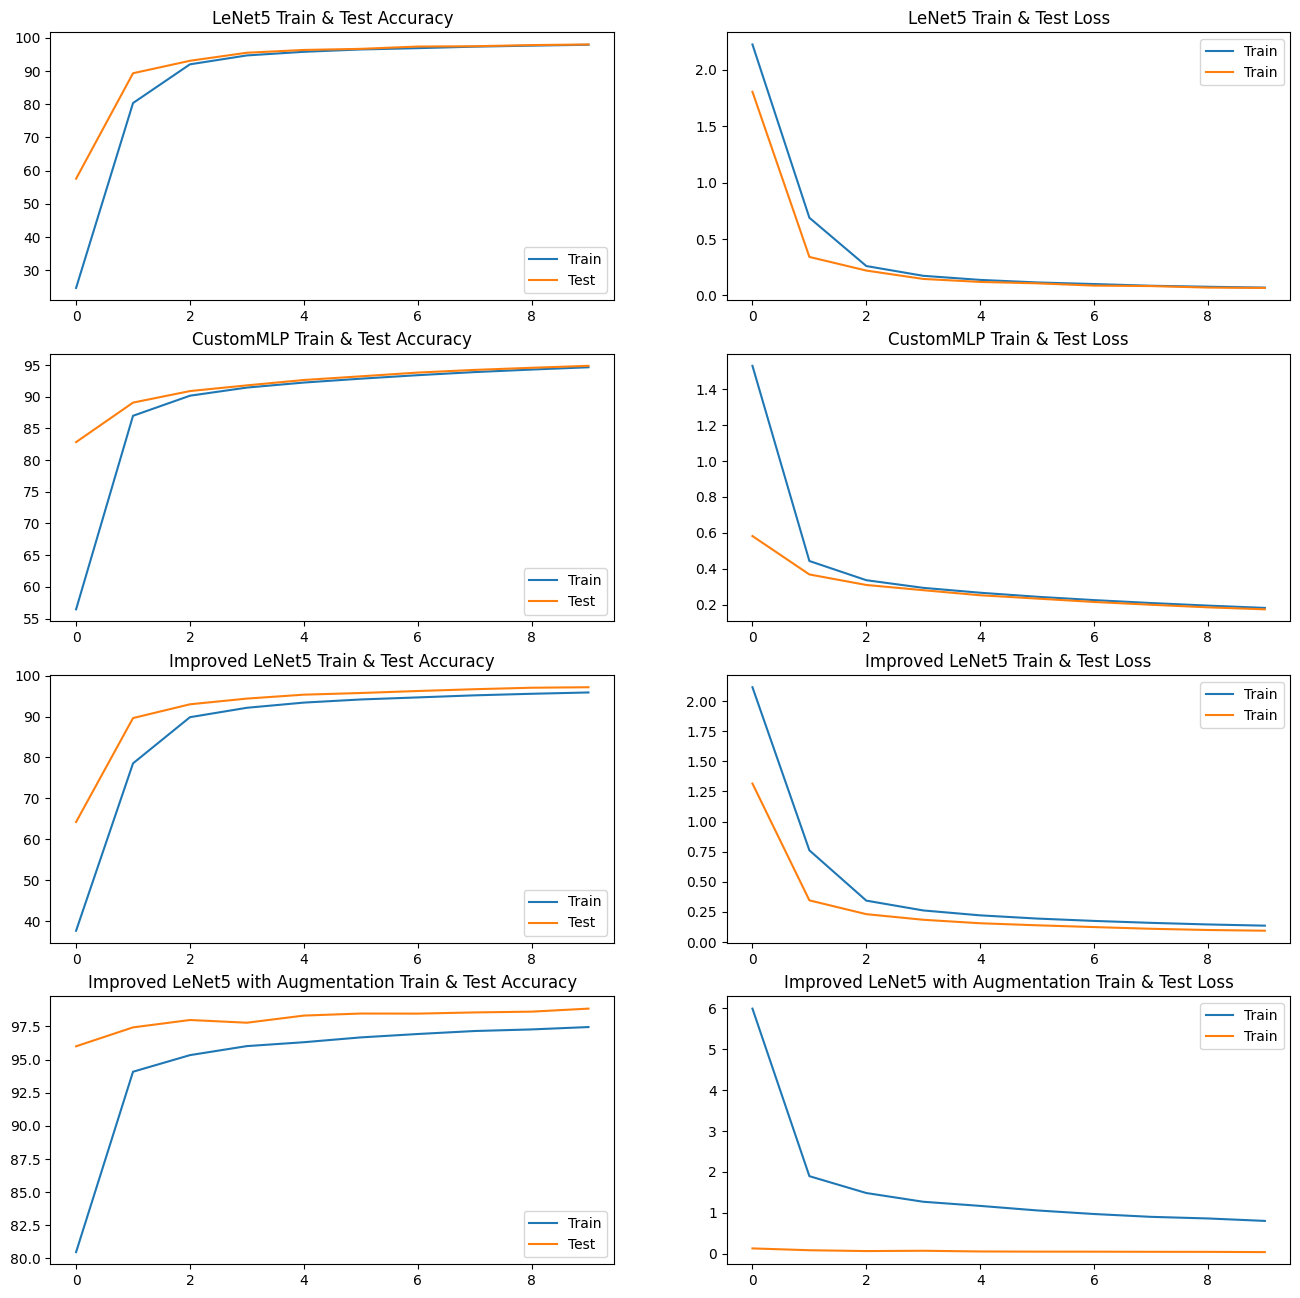

In [24]:
fig, axes = plt.subplots(4, 2, figsize=(16, 16))

axes[0, 0].plot(LeNet5_train_acc, label = 'Train')
axes[0, 0].plot(LeNet5_test_acc, label = 'Test')
axes[0, 0].set_title('LeNet5 Train & Test Accuracy')
axes[0, 0].legend()

axes[0, 1].plot(LeNet5_train_loss, label = 'Train')
axes[0, 1].plot(LeNet5_test_loss, label = 'Train')
axes[0, 1].set_title('LeNet5 Train & Test Loss')
axes[0, 1].legend()

axes[1, 0].plot(cM_train_acc, label = 'Train')
axes[1, 0].plot(cM_test_acc, label = 'Test')
axes[1, 0].set_title('CustomMLP Train & Test Accuracy')
axes[1, 0].legend()

axes[1, 1].plot(cM_train_loss, label = 'Train')
axes[1, 1].plot(cM_test_loss, label = 'Train')
axes[1, 1].set_title('CustomMLP Train & Test Loss')
axes[1, 0].legend()

axes[2, 0].plot(Imp_LeNet5_train_acc, label = 'Train')
axes[2, 0].plot(Imp_LeNet5_test_acc, label = 'Test')
axes[2, 0].set_title('Improved LeNet5 Train & Test Accuracy')
axes[2, 0].legend()

axes[2, 1].plot(Imp_LeNet5_train_loss, label = 'Train')
axes[2, 1].plot(Imp_LeNet5_test_loss, label = 'Train')
axes[2, 1].set_title('Improved LeNet5 Train & Test Loss')
axes[2, 1].legend()

axes[3, 0].plot(Imp_LeNet5_ag_train_acc, label = 'Train')
axes[3, 0].plot(Imp_LeNet5_ag_test_acc, label = 'Test')
axes[3, 0].set_title('Improved LeNet5 with Augmentation Train & Test Accuracy')
axes[3, 0].legend()

axes[3, 1].plot(Imp_LeNet5_ag_train_loss, label = 'Train')
axes[3, 1].plot(Imp_LeNet5_ag_test_loss, label = 'Train')
axes[3, 1].set_title('Improved LeNet5 with Augmentation Train & Test Loss')
axes[3, 1].legend()

# plt.tight_layout()
plt.show()

## LeNet5 vs CustomMLP vs Improved LeNet5 vs Improved LeNet5 with Augmentation
- Compare overall results
- Regularization techniques require relatively large amounts of data to improve performance, so the performance of the Improved Model was slightly degraded compared to the base model.
- However, it is observed that the most significant performance improvement is achieved when augmentation is applied.


In [25]:
print(f'LeNet5 Best Accuracy: {max(LeNet5_test_acc)}')
print(f'CustomMLP Best Accuracy: {max(cM_test_acc)}')
print(f'Improved LeNet5 Best Accuracy: {max(Imp_LeNet5_test_acc)}')
print(f'Improved LeNet5 with Augmentation Best Accuracy: {max(Imp_LeNet5_ag_test_acc)}')

LeNet5 Best Accuracy: 98.02333333333333
CustomMLP Best Accuracy: 94.87666666666667
Improved LeNet5 Best Accuracy: 97.16333333333333
Improved LeNet5 with Augmentation Best Accuracy: 98.84666666666666


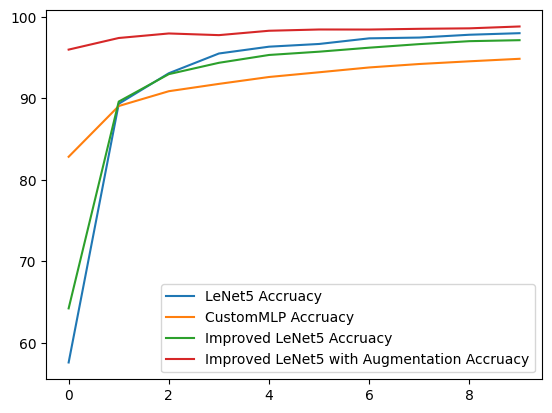

In [26]:
plt.plot(LeNet5_test_acc, label = 'LeNet5 Accruacy')
plt.plot(cM_test_acc, label = 'CustomMLP Accruacy')
plt.plot(Imp_LeNet5_test_acc, label = 'Improved LeNet5 Accruacy')
plt.plot(Imp_LeNet5_ag_test_acc, label = 'Improved LeNet5 with Augmentation Accruacy')

plt.legend()
plt.show()